# Goal

Train model

Thanks to: OBELISK, FAIMED3D, MONAI
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

# Setup parameters

In [1]:
do_reload = True #True #True #False
if do_reload:
    %load_ext autoreload
    %autoreload 2

In [2]:
# kwargs = dict(arg.split("=") for arg in sys.argv if "=" in arg)
# print(kwargs)

# model_type = kwargs["model_type"]
# loss_type  = kwargs["loss"]

# print(f"Model: {model_type}")
# print(f"Loss : {loss_type}")

In [3]:
model_type = "VNET" # VNET, UNET3D, UNETR, SegResNetVAE, OBELISKHYBRID
loss_type  = "BCE_loss" # DICE_loss

In [4]:
# import os

# try:
#     taskid = int(os.getenv('SLURM_ARRAY_TASK_ID'))
# except:
#     taskid = 0

# taskid = 1
# print(f"Taskid: {taskid}")

# if taskid == 0:
#     # MODEL & LOSS
#     model_type = "UNET3D" #"SegResNetVAE" # "UNET3D" #"OBELISKHYBRID" #"VNET" # "UNET3D" "OBELISKHYBRID"
#     loss_type  = "BCE_loss" #"log_cosh_dice_loss" #"vae_loss" #"perim_loss" #"log_cosh_dice_loss" # DICE
# elif taskid == 1:
#     # MODEL & LOSS
#     model_type = "UNET3D" #"SegResNetVAE" # "UNET3D" #"OBELISKHYBRID" #"VNET" # "UNET3D" "OBELISKHYBRID"
#     loss_type  = "log_cosh_dice_loss" #"log_cosh_dice_loss" #"vae_loss" #"perim_loss" #"log_cosh_dice_loss" # DICE
# else:
#     print("Taskid {taskid} not recognized.")
    
print(f"Model: {model_type}")
print(f"Loss : {loss_type}")

Model: VNET
Loss : BCE_loss


In [5]:
# MODEL & LOSS
# model_type = "UNET3D" #"SegResNetVAE" # "UNET3D" #"OBELISKHYBRID" #"VNET" # "UNET3D" "OBELISKHYBRID"
# loss_type  = "BCE_loss" #"log_cosh_dice_loss" #"vae_loss" #"perim_loss" #"log_cosh_dice_loss" # DICE

# DATALOADER PARAMS
bs          = 1
nepochs     = 60
num_workers = 2
full_res      = (96,96,96)

In [6]:
from helpers.model_loss_choices import get_model, get_loss

model   = get_model(model_type, full_res)
loss_fn = get_loss(loss_type) 

Full lbl items: 335
Removed 2 weird, new total lbl items: 333
train, valid, test 201 66 66 total 333
Cross label items:  418
All label items:  751 (abide (333) + cross_lbl (418))
Test label items:  484 (test (66) + cross_lbl (418))


In [7]:
import os, shutil

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference


from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.6.dev2127
Numpy version: 1.19.5
Pytorch version: 1.7.1+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 889f33577be13b590211663995d2285aafc8fd74

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.2.0
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.8.2+cu101
ITK version: 5.1.2
tqdm version: 4.61.2
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.5
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Items as dict 

In [8]:
from helpers.items_constants import *
train_itemsd = getd(train_items)[:50]
val_itemsd   = getd(valid_items)[:50]
print(f"train: {len(train_itemsd)}, val: {len(val_itemsd)}")

train: 50, val: 50


# Transforms

In [9]:
from helpers.transforms import UndoDict, get_train_valid_transforms

train_tfms, val_tfms = get_train_valid_transforms(full_res)

In [10]:
# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *
from fastai.callback.all import SaveModelCallback, CSVLogger

In [11]:
# tls, dls, cuda
train_dl = TfmdDL(train_itemsd, after_item=train_tfms, after_batch=[], bs=bs)
val_dl   = TfmdDL(val_itemsd,   after_item=val_tfms,   after_batch=[], bs=bs)

In [12]:
dls = DataLoaders(train_dl, val_dl)
dls = dls.cuda()

In [13]:
# # Viz

# from helpers.viz        import viz_axis, viz_compare_inputs, viz_compare_outputs
# from helpers.preprocess import mask2bbox
# from helpers.general    import lrange

# b = dls.one_batch()

# xb = b["image"]
# yb = b["label"]

# print("shape xb yb", xb.shape, yb.shape)

# i = 0
# mr = np.array(xb[i].squeeze())
# mk = np.array(yb[i].squeeze())

# bbox = mask2bbox(mk)

# viz_axis(np_arr = mr, \
#     bin_mask_arr   = mk,     color1 = "yellow",  alpha1=0.3, \
#     slices=lrange(*bbox[0:2]), fixed_axis=0, \
#     axis_fn = np.rot90, \
#     title   = "Axis 0", \

#     np_arr_b = mr, \
#     bin_mask_arr_b   = mk,     color1_b = "yellow",  alpha1_b=0.3, \
#     slices_b = lrange(*bbox[2:4]), fixed_axis_b=1, \
#     title_b  = "Axis 1", \

#     np_arr_c = mr, \
#     bin_mask_arr_c   = mk,     color1_c = "yellow",  alpha1_c=0.3, \
#     slices_c = lrange(*bbox[4:6]), fixed_axis_c=2, \
#     title_c = "Axis 2", \
  
# ncols = 5, hspace=0.3, fig_mult=2)

In [14]:
# Utilities
import os, sys, gc, time, pickle
from pathlib import Path

# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *
from fastai.callback.all import SaveModelCallback, CSVLogger

In [15]:
# length  = len(items)
# indices = np.arange(length)
# np.random.shuffle(indices)
# #rank0_first(lambda: np.random.shuffle(indices))

# test_split   = int(test_frac  * length)
# valid_split  = int(valid_frac * length) + test_split

# test_idxs    = indices[:test_split] 
# valid_idxs   = indices[test_split:valid_split]
# train_idxs   = indices[valid_split:]

# train_items = [items[i] for i in train_idxs]
# valid_items = [items[i] for i in valid_idxs]
# test_items  = [items[i] for i in test_idxs]

# # print
# print(f"Total  {len(items)} items in dataset.")
# print(f"Train: {len(train_items)} items.")
# print(f"Valid: {len(valid_items)} items.")
# print(f"Test:  {len(test_items)} items.")

In [16]:
# # save test set indices
# with open(f"{data_src}/saved_dset_metadata/split_train_valid_test.pkl", 'wb') as f:
#     pickle.dump([train_idxs, valid_idxs, test_idxs, train_items, valid_items, test_items], f)

In [17]:
# test get one batch
# time_one_batch(dls)

In [18]:
# Save test idxs + model + runs
from helpers.time       import time_one_batch, get_time_id

# file name
model_time = rank0_first(lambda:get_time_id()) # 'Mon Oct 18 13:35:29 2010'
model_name = f"model_{model_type}_loss_{loss_type}_bs_{bs}_epochs_{nepochs}_time_{model_time}"
print(f"Model name: {model_name}")

Model name: model_VNET_loss_BCE_loss_bs_1_epochs_60_time_1627819388_Sun_Aug_01_2021_hr_08_min_03


# Save

In [19]:
# make dir
model_src = f"{run_src}/{model_name}"
fig_src = f"{model_src}/figs"
Path(fig_src).mkdir(parents=True, exist_ok=True)

In [20]:
# # save test set indices
# with open(f"{model_src}/test_items.pkl", 'wb') as f:
#     rank0_first(lambda:pickle.dump(list(test_items), f))

# # save data augs
# with open(f"{model_src}/data_augs.txt", 'w') as f:
#     rank0_first(lambda: 
#                     print("Train Tfms: "), print(monai_tfms2str(train_tfms, file=f)); print("\n", file=f);
#                     print("Val   Tfms: "), print(monai_tfms2str(val_tfms, file=f))
#                )

# #     s = "\n".join([str(tfm) for tfm in train_tfms.transforms] + [f"Pixdim: 1.5"])
# #     rank0_first(lambda: print(s, file=f))
    
# # with open(f"{model_src}/{model_name}_test_items.pkl", 'wb') as f:
# #     rank0_first(lambda:pickle.dump(list(test_items), f))

# Callbacks

In [21]:
cbs = [
    rank0_first(lambda: Recorder(train_metrics=True)),
    rank0_first(lambda: SaveModelCallback(monitor='valid_loss', with_opt=True)), 
    rank0_first(lambda: CSVLogger(fname=f"{fig_src}/history.csv"))
]

# class PerimLossMidway(Callback):
#     def before_epoch(self): 
#         if self.epoch == self.n_epoch//2:
#             self.learn.loss_func = perim_loss
#             print("Changed ", self.learn.loss_func, "at epoch ", self.n_epoch//2)
            
# cbs = [SaveModelCallback(monitor='dice_score', with_opt=True), CSVLogger(fname=f"{fig_src}/history.csv")]

# if loss_type == "perim_loss":
#     print("added PerimLoss callback")
#     cbs.append(PerimLossMidway())

# Learner

In [22]:
# clear cache
from helpers.general import print_hardware_stats

gc.collect()
torch.cuda.empty_cache()
rank0_first(lambda: print_hardware_stats())

#GPU = 1, #CPU = 40
GPU Tesla V100-SXM2-16GB RAM Free: 16157MB | Used: 3MB | Util   0% | Total 16160MB


In [23]:
from helpers.losses import dice_score

In [24]:
loss_fn = get_loss(loss_type) 

In [32]:
learn = rank0_first(lambda:
            Learner(dls   = dls, \
                model     = model, \
                loss_func = loss_fn, \
                metrics   = dice_score, \
                model_dir = model_src, \
                cbs       = cbs)
        )

# cbs TensorBoardCallback(Path(run_src)/model_name, trace_model=True)
# GPU
learn.model = rank0_first(lambda:learn.model.cuda())

In [33]:
# # check
# print("Check")
# b = dls.one_batch()
# xb,yb = b #b["image"], b["label"]
# print(f"Batch: {len(b)}. xb: {xb.shape}, yb: {yb.shape}")
# predb = learn.model(xb)
# print(f"Pred batch: {predb.shape}")
# loss = loss_fn(predb, yb)
# print(f"Loss: {loss}")

In [34]:
# print(predb[0].shape, predb[1])

# LR Finder

In [35]:
# print("PRE learn.fit one cycle")
# with learn.distrib_ctx():
#     learn.fit_one_cycle(2, 3e-3, wd = 1e-4)

In [36]:
learn.recorder.metric_names

ModuleAttributeError: 'VNet' object has no attribute 'metric_names'

SuggestedLRs(valley=tensor(0.0044))

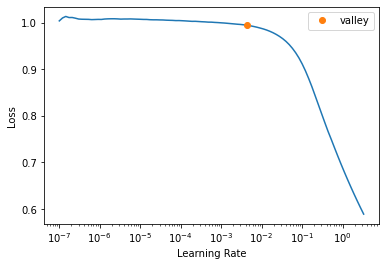

In [29]:
# SuggestedLRs(valley=tensor(0.0229))
learn.lr_find()

In [37]:
print("PRE learn.fit one cycle")

nepochs=2
with learn.distrib_ctx():
    learn.fit_one_cycle(nepochs, 3e-3, wd = 1e-4)
    

PRE learn.fit one cycle


Better model found at epoch 0 with valid_loss value: 1.3442639112472534.


In [ ]:
#     if loss_type == "perim_loss":
#         learn.loss_func = perim_loss
#         print("switched loss at epoch ", nepochs//2)
    
#     learn.fit_one_cycle(nepochs//2, 3e-3, wd = 1e-4)

In [30]:
#learn.recorder.plot_loss()

ModuleAttributeError: 'VNet' object has no attribute 'losses'

In [ ]:
def save_plot_loss(self, skip_start=5, with_valid=True):
        plt.plot(list(range(skip_start, len(self.losses))), self.losses[skip_start:], label='train')
        if with_valid:
            idx = (np.array(self.iters)<skip_start).sum()
            plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(1), label='valid')
            plt.legend()
        plt.savefig(f'{fig_src}/loss.png', bbox_inches='tight')
        plt.close()

In [ ]:
# save_plot_loss(learn.recorder)

['epoch', 'train_loss', 'train_dice_score', 'valid_loss', 'valid_dice_score', 'time']
0 2 train_loss valid_loss
1 3 train_dice_score valid_dice_score


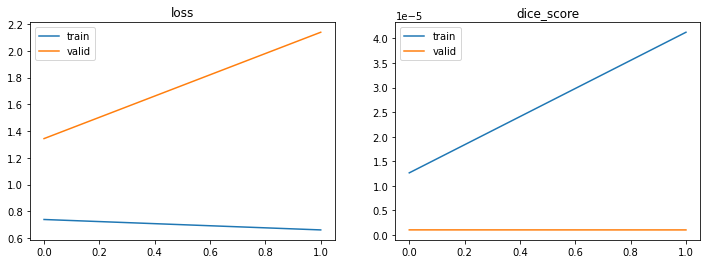

In [55]:
self = learn.recorder
nrows=None 
ncols=None
figsize=None,
metrics = np.stack(self.values)
print(self.metric_names)

# 'train_loss', 'train_dice_score', 'valid_loss', 'valid_dice_score'
names = self.metric_names[1:-1]
names_train = [n for n in names if n.startswith("train")]
n = len(names_train)
if nrows is None and ncols is None:
    nrows = int(math.sqrt(n))
    ncols = int(np.ceil(n / nrows))
elif nrows is None: nrows = int(np.ceil(n / ncols))
elif ncols is None: ncols = int(np.ceil(n / nrows))
figsize = (ncols * 6, nrows * 4)
fig, axs = subplots(nrows, ncols, figsize=figsize)
for i, ax in enumerate(axs):
    name = names_train[i]
    n = name[name.index("_")+1:]
    valid_name = f"valid_{n}"
    valid_idx = names.index(valid_name)
    print(i, valid_idx, name, valid_name)
    ax.plot(metrics[:, i], color='#1f77b4',  label='train')
    ax.plot(metrics[:, valid_idx], color = '#ff7f0e', label='valid')
    ax.set_title(n)
    ax.legend(loc='best')

In [ ]:
@delegates(subplots)
def save_plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    #plt.show()
    plt.savefig(f'{fig_src}/metrics.png', bbox_inches='tight')
    plt.close()

In [ ]:
save_plot_metrics(learn.recorder)

# Old

In [ ]:
# batch_tfms = [
#     # normalize mean/std of foreground pixels
#     ZScale(),
#     # affine + flips
#     RandomAffine(p=0.5, degrees=35, translate=0.1, scale=0.1),
#     RandDihedral(p=0.5),
#     # lighting
#     RandBright(p=0.5),
#     RandContrast(p=0.5),
#     # noise for generalizability
#     GNoise(p=0.5),
#     GBlur(p=0.5),
#     # add channel dim
#     AddChannel()

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

# ]

# Test

In [ ]:
# print("Test")
# xb, yb = dls.one_batch()
# xb, yb = xb.cpu(), yb.cpu()

# pb = model.cpu()(xb)
# print(xb.shape, pb.shape)
# print(f"logcosh dice loss {log_cosh_dice_loss(pb,yb)}")

In [ ]:
# # test:

# #dls.device = "cpu"

# start = time.time()

# x,y = dls.one_batch()
# #x,y = to_cpu(x), to_cpu(y)

# pred = learn.model(x)
# loss = learn.loss_func(pred, y)

# elapsed = time.time() - start

# print(f"Elapsed: {elapsed} s")
# print("Batch: x,y")
# print(type(x), x.shape, x.dtype, "\n", type(y), y.shape, y.dtype)

# print("Pred shape")
# print(type(pred), pred.shape, pred.dtype)

# print("Loss")
# print(loss)
# print(learn.loss_func)